In [ ]:
!gunzip "processed_rjokes_all.csv.gz"

In [ ]:
!gunzip "processed_askreddit_all.csv.gz"

#TOPIC MODELING

##LDA

In [ ]:
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.matutils import corpus2csc

processed_text = data["Processed_Text"].astype(str).apply(lambda x: x.split())
dictionary = Dictionary(processed_text)
dictionary.filter_extremes(no_below=5, no_above=0.5)
bow_corpus = [dictionary.doc2bow(text) for text in processed_text]
# CHOOSE NUM_TOPICS
num_topics = 50

ldamodel = LdaModel(bow_corpus, num_topics=num_topics, id2word=dictionary, passes=20, alpha="auto", eta="auto")

topics = ldamodel.show_topics(num_topics=num_topics, num_words=20, log=False, formatted=False)

for topic_id, topic in topics:
  print("Topic: {}".format(topic_id))
  print("Words: {}".format([word for word,_ in topic]))
cm = CoherenceModel(model=ldamodel, texts=processed_text, dictionary=dictionary, coherence='c_v')
coherence = cm.get_coherence()  # get coherence value
print(num_topics, " ", coherence)

Topic: 0
Words: ['covid', 'memory', 'meal', 'top', 'version', 'paid', 'order', 'full', 'wedding', 'weapon', 'ice', 'hole', 'zombie', 'serial', 'apocalypse', 'cream', 'finish', 'purpose', 'vaccine', 'employer']
Topic: 1
Words: ['last', 'today', 'user', 'reason', 'relationship', 'book', 'popular', 'earth', 'line', 'help', 'worth', 'crush', 'conversation', 'outside', 'speak', 'argument', 'sell', 'insane', 'flat', 'pickup']
Topic: 2
Words: ['“', 'actually', '”', 'attractive', 'happy', 'week', 'craziest', 'view', 'depressed', 'water', 'driver', 'share', 'amp', 'hated', 'becomes', 'literally', 'soundtrack', 'tourist', 'generally', 'finding']
Topic: 3
Words: ['keep', 'minute', 'living', 'million', 'hard', 'customer', 'lady', 'quit', 'group', 'thinking', 'discovered', 'stopped', 'original', 'impact', 'invention', 'simply', 'standard', 'special', 'introvert', 'consequence']
Topic: 4
Words: ['guy', 'find', 'moment', 'real', 'instantly', 'didnt', 'wake', 'point', 'yet', 'fall', 'stay', 'ability',

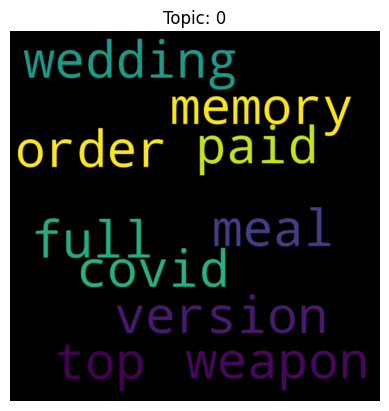

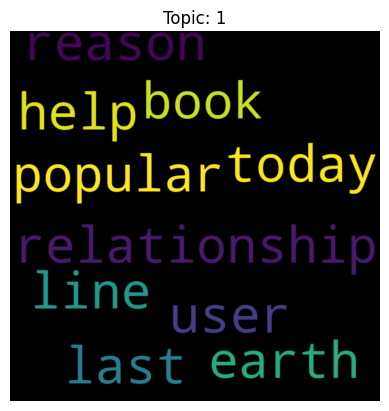

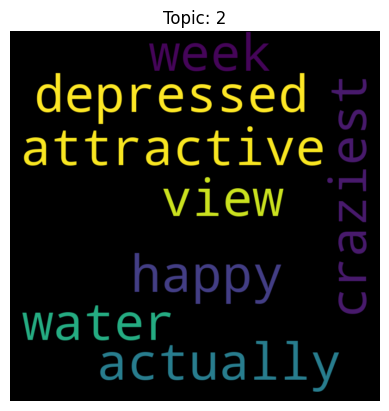

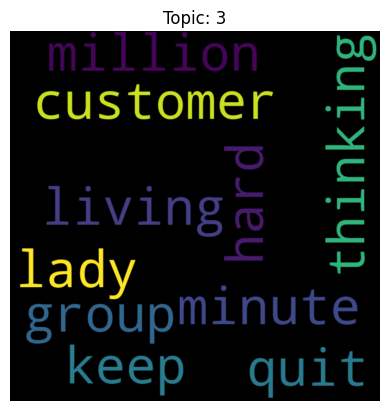

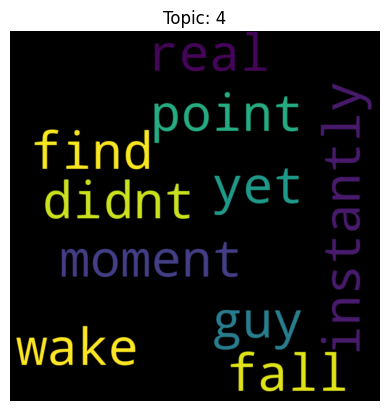

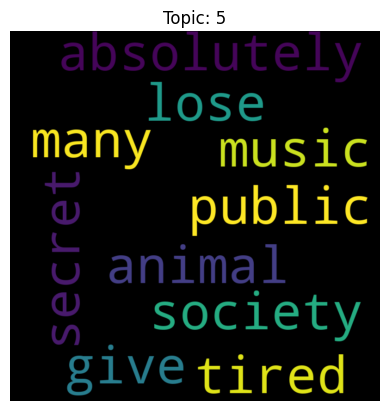

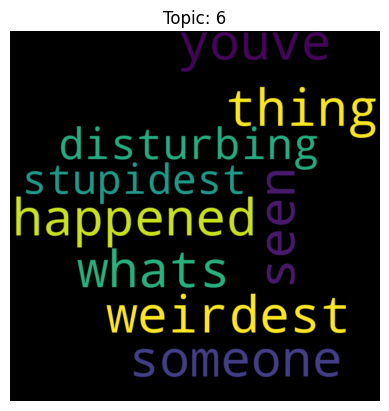

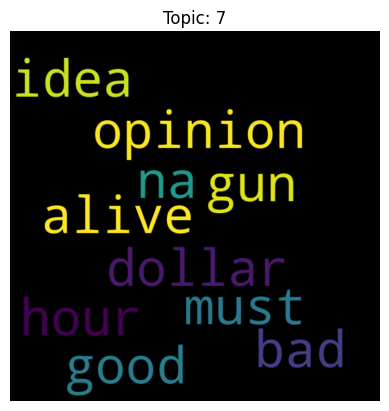

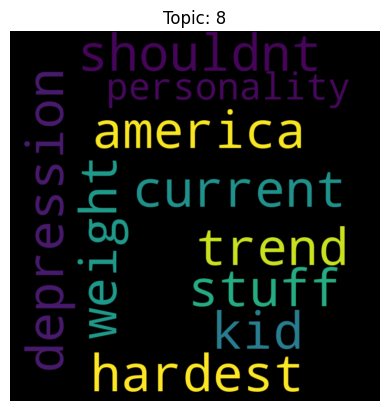

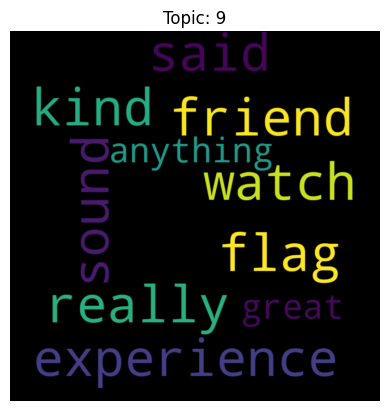

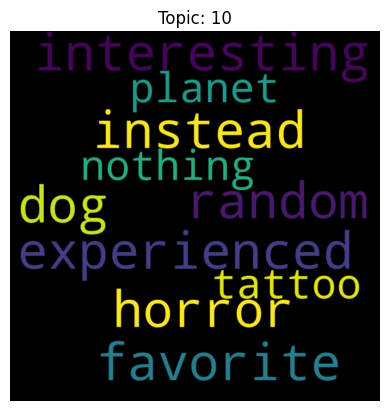

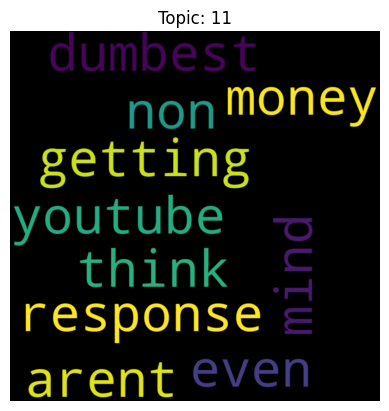

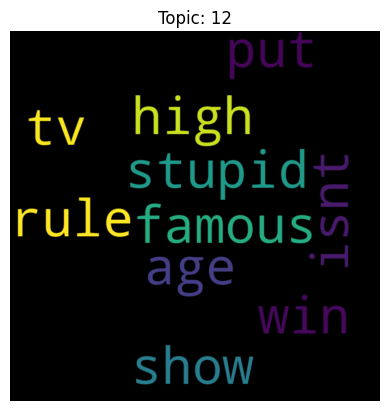

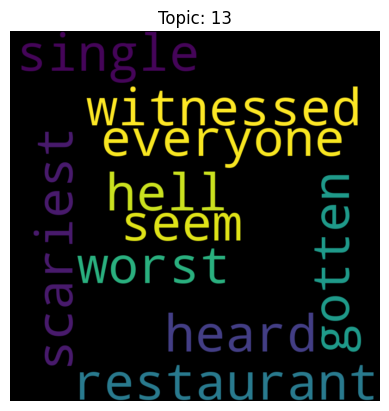

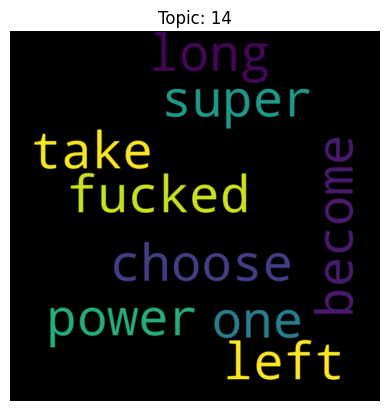

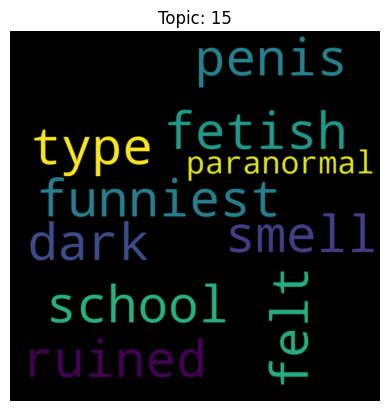

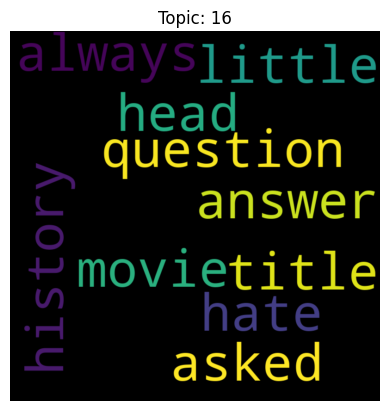

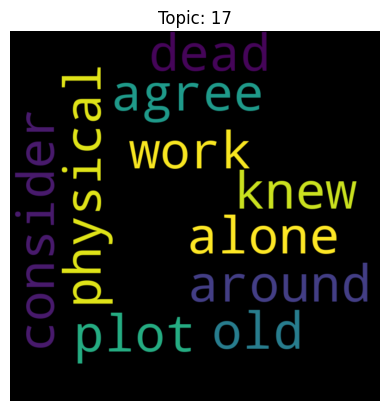

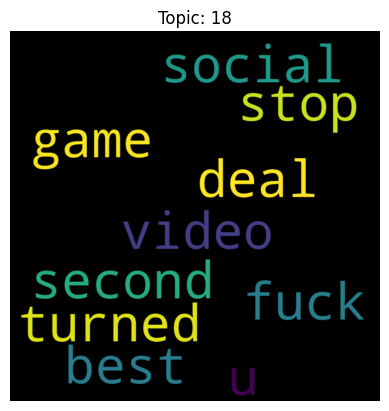

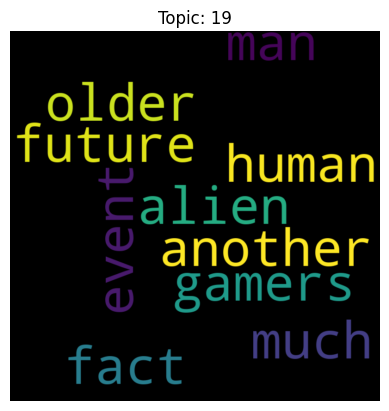

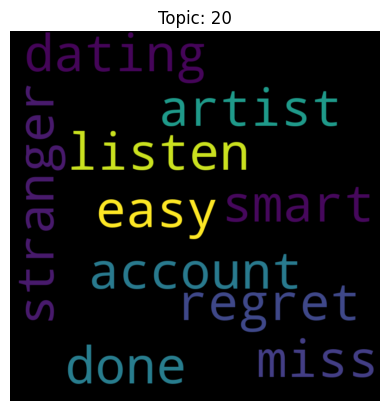

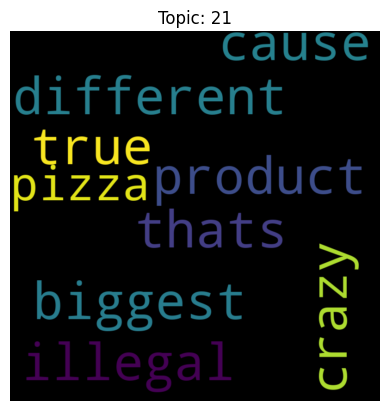

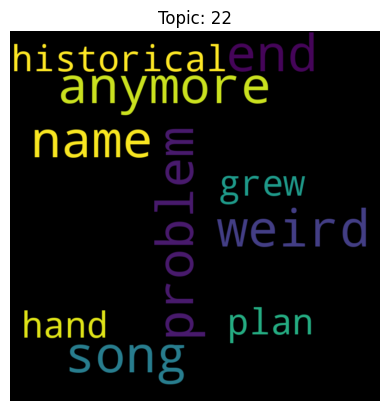

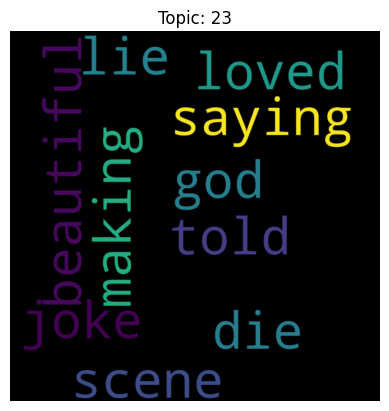

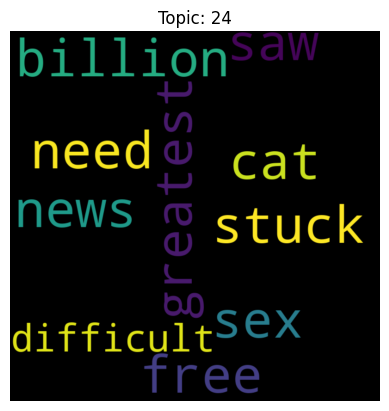

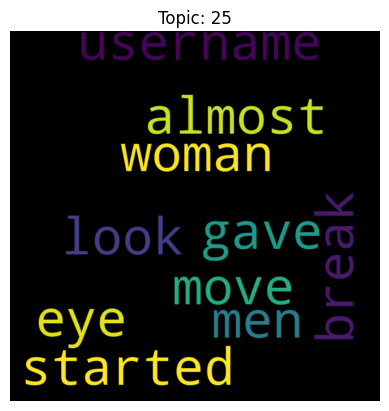

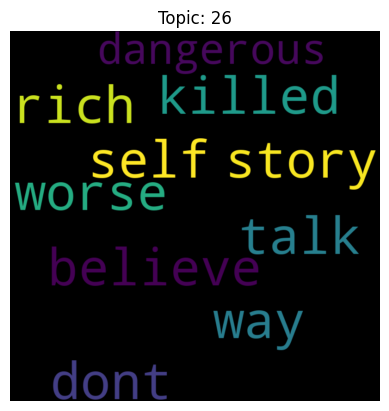

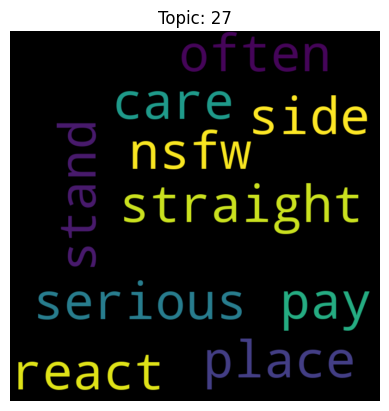

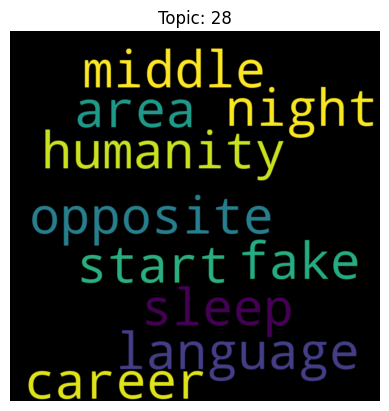

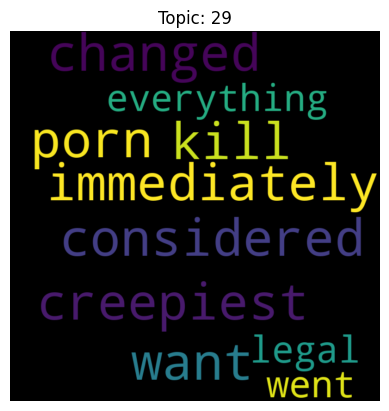

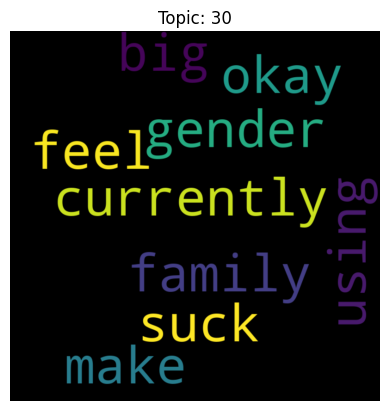

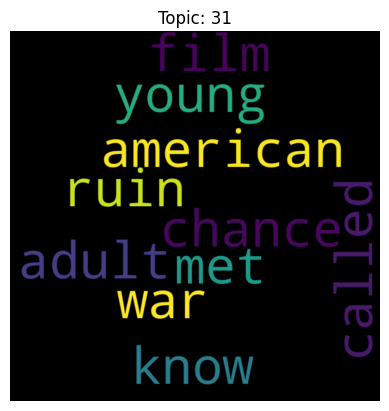

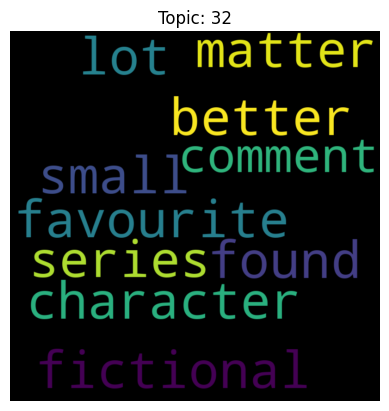

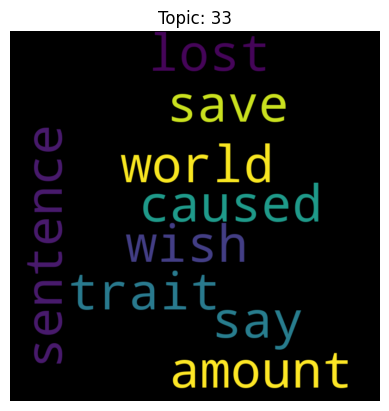

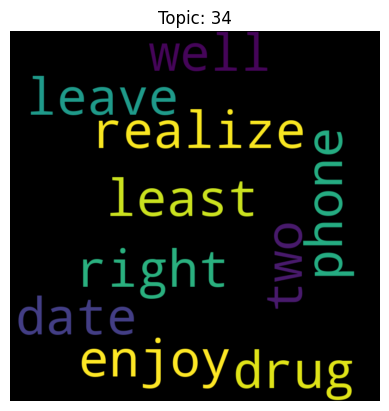

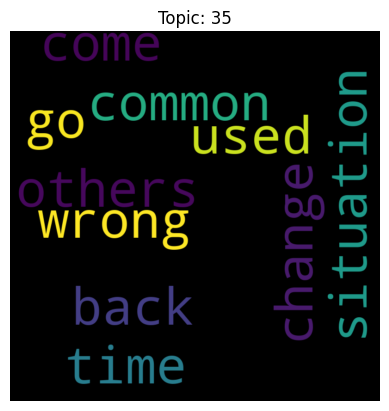

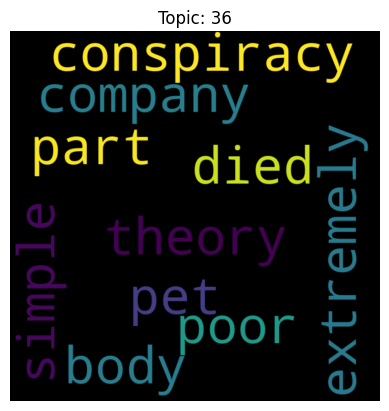

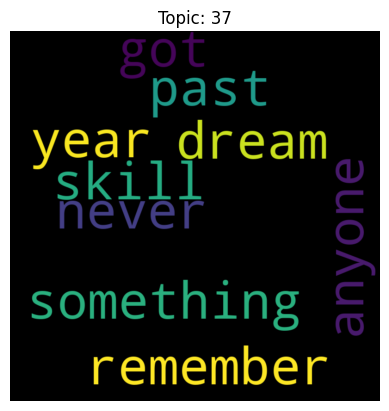

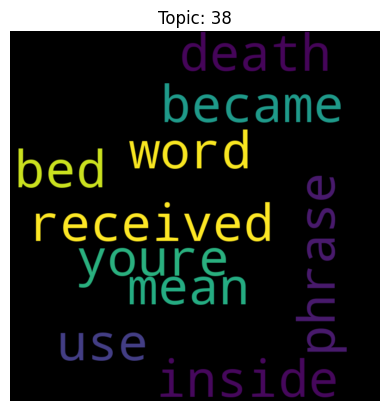

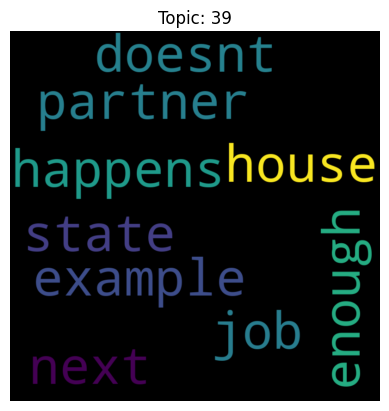

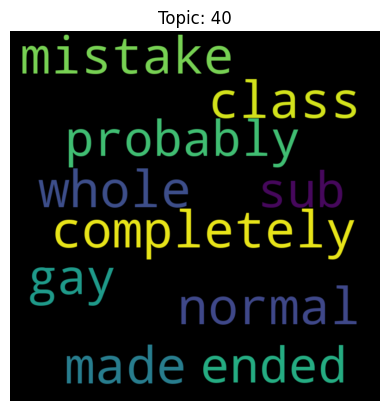

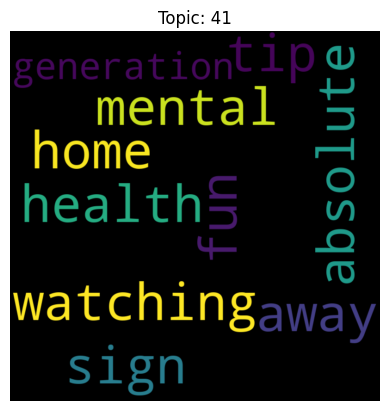

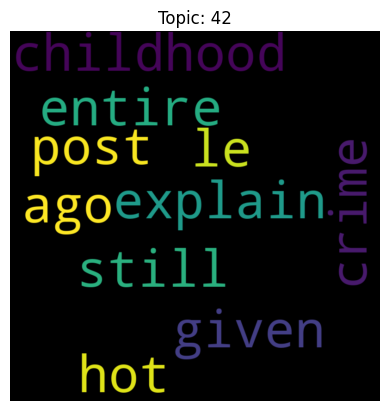

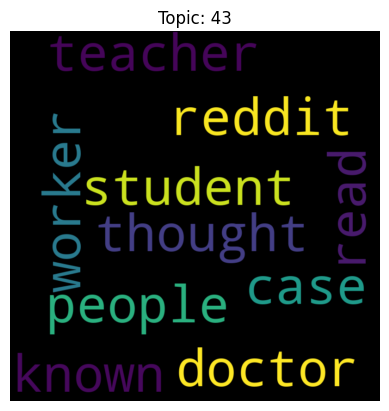

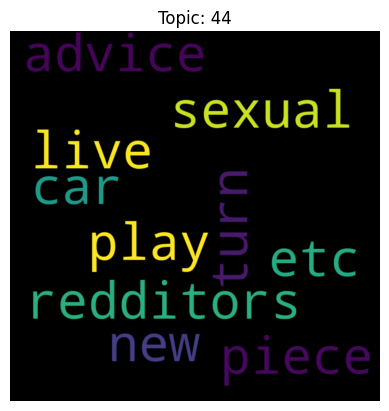

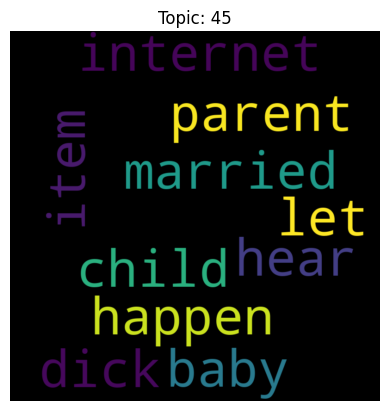

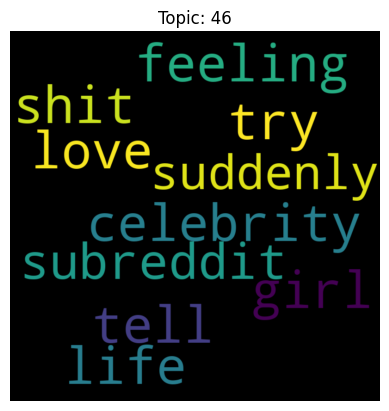

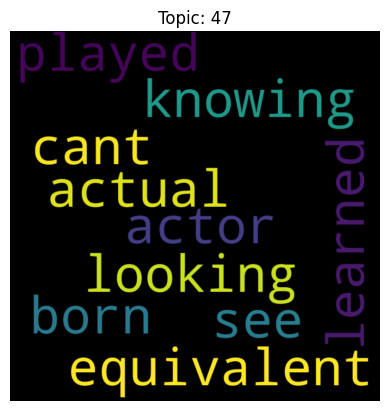

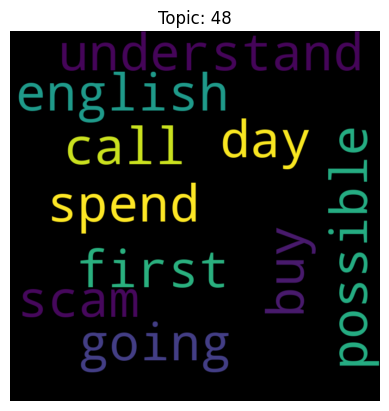

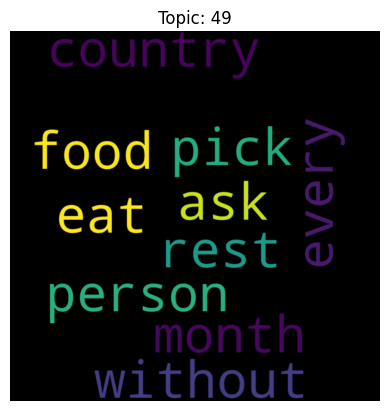

In [ ]:
# Plotting a wordcloud of the topics
from wordcloud import WordCloud
for topic_id, topic in enumerate(ldamodel.print_topics(num_topics=num_topics, num_words=10)):
    topic_words = " ".join([word.split("*")[1].strip() for word in topic[1].split(" + ")])
    wordcloud = WordCloud(width=800, height=800, random_state=21, max_font_size=110).generate(topic_words)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Topic: {}".format(topic_id))
    plt.show()

##BERTopic

In [ ]:
!pip install bertopic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 19.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 14.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 13.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached Cython-0.29.36-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 6.1 MB/s eta 0:00:00
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=3039176 sha256=815b1bd8334b9889c990dac08bbeceb5338f35cef51d84eb9875e0181b3406b0
  Stored in di

In [ ]:
temp_data = data.loc[data['label'].values == 'Popular', :]
docs = temp_data['joke'].astype(str).tolist()

In [ ]:
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN

# Pre-calculate embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedding_model.encode(docs, show_progress_bar=True)

Batches:   0%|          | 0/2064 [00:00<?, ?it/s]

In [ ]:
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=200, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
vectorizer_model = CountVectorizer(stop_words="english", min_df=2, max_df=1.0, ngram_range=(1, 1))
keybert_model = KeyBERTInspired()
topic_model = BERTopic(

  # Pipeline models
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  vectorizer_model=vectorizer_model,
  representation_model=keybert_model,

  # Hyperparameters
  top_n_words=10,
  verbose=True
)

# Train model
topics, probs = topic_model.fit_transform(docs, embeddings)

2023-12-14 18:10:06,702 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2023-12-14 18:11:41,139 - BERTopic - Dimensionality - Completed ✓
2023-12-14 18:11:41,143 - BERTopic - Cluster - Start clustering the reduced embeddings
2023-12-14 18:11:57,995 - BERTopic - Cluster - Completed ✓
2023-12-14 18:11:58,026 - BERTopic - Representation - Extracting topics from clusters using representation models.
2023-12-14 18:12:09,245 - BERTopic - Representation - Completed ✓


In [ ]:
all_topics = topic_model.get_topic_info()
all_topics

,Topic,Count,Name,Representation,Representative_Docs
0,-1,35957,-1_wife_best_couple_husband,"[wife, best, couple, husband, good, door, sex,...","[The husband leans over and asks his wife, ""Do..."
1,0,2935,0_heaven_peter_catholic_church,"[heaven, peter, catholic, church, sinned, pope...",[Getting Married In Heaven On their way to get...
2,1,1758,1_johnny_teacher_dad_father,"[johnny, teacher, dad, father, kid, mum, daddy...",[Little Johnny was told by his friends that ad...
3,2,1283,2_girlfriend_cheating_sister_dumped,"[girlfriend, cheating, sister, dumped, relatio...",[My girlfriend broke up with me so I took her ...
4,3,1247,3_policeman_officer_cop_officers,"[policeman, officer, cop, officers, police, co...",[Blond woman has been stopped by police becous...
...,...,...,...,...,...
86,85,105,85_knocking_knockers_knocks_knock,"[knocking, knockers, knocks, knock, door, gran...",[Knock knockWho's there?\n\nYanny\n\nLaurel wh...
87,86,103,86_twin_twins_unattractive_tell,"[twin, twins, unattractive, tell, alike, datin...",[I once dated a girl with a twin. People asked...
88,87,103,87_godfather_guido_mafia_teller,"[godfather, guido, mafia, teller, enzo, robber...",[The Deaf Mafia Bookkeeper A mafia Godfather f...
89,88,102,88_spider_spiderman_spiders_developer,"[spider, spiderman, spiders, developer, web, k...",[My wife told me to take the spider out instea...


In [ ]:
temp_data['topic'] = topic_model.get_document_info(docs)['Topic'].tolist()

In [ ]:
all_topics['mean_score'] = temp_data.groupby(['topic'])["score"].mean()
all_topics[['Topic', 'mean_score', 'Name', 'Representation', 'Count']].sort_values('mean_score',ascending=False)

,Topic,mean_score,Name,Representation,Count
57,56,8118.122581,56_batman_robin_bat_bats,"[batman, robin, bat, bats, batgirl, joker, sup...",155
85,84,8002.923810,84_eclipse_solar_sun_moon,"[eclipse, solar, sun, moon, sky, lighthouse, s...",106
42,41,7379.482412,41_vegans_vegan_vegetarian_meat,"[vegans, vegan, vegetarian, meat, bacon, cross...",201
6,5,6754.984088,5_removed_deleted_user_banned,"[removed, deleted, user, banned, wrote, mods, ...",915
72,71,6356.782258,71_threesome_foursome_twosome_trois,"[threesome, foursome, twosome, trois, sex, cou...",126
...,...,...,...,...,...
45,44,2305.854651,44_h2o_chemist_hydrogen_chemists,"[h2o, chemist, hydrogen, chemists, chemistry, ...",179
78,77,2297.930435,77_boobs_sunglasses_breasts_breast,"[boobs, sunglasses, breasts, breast, tits, nip...",117
77,76,2169.982906,76_cowboy_horse_horses_tribesmen,"[cowboy, horse, horses, tribesmen, cattle, ind...",119
44,43,1971.837989,43_thesaurus_dictionary_pronounced_words,"[thesaurus, dictionary, pronounced, words, cal...",199


In [ ]:
all_topics.to_csv('rjokes_BERTopic.csv')

#PREPARATION

##choose options to run

dataset, classification or regression, what features to use, use pre-trained glove or not

In [ ]:
dataset_option = 0 # 0 is rjokes, 1 is askreddit
task_option = 0 # 0 is classification, 1 is regression
model_option = 0 # 0 is 1 input, 1 is 2 inputs
glove_option = 0 # 0 is not used pre-trained GLOVE, 1 is use pre-trained glove
feature_option = 0 # 0 is text only, 1 is text + date

BATCH_SIZE = 32

##PREPARE DATASET

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

###load data

In [ ]:
if dataset_option == 0:
  data = pd.read_csv("processed_rjokes_all.csv")
  feature_name = 'joke'
  label_name = 'label'
  score_threhold = 300
else:
  data = pd.read_csv("processed_askreddit_all.csv")
  feature_name = 'title'
  label_name = 'label'
  score_threhold = 100
time_name = 'created_hour'
data

,Unnamed: 0,joke,body,punchline,score,date,label,Processed_Text,created_hour
0,0,I hope you're all getting your Walter Cronkite...,"Here's mine. \n\nEd McMahon, David Carradine, ...",I hope you're all getting your Walter Cronkite...,9.0,1.246240e+09,Unpopular,hope youre getting walter cronkite joke order ...,1
1,1,What is the only thing a woman can say that wi...,"""Your dick is bigger than your brother's.""",What is the only thing a woman can say that wi...,25.0,1.247151e+09,Unpopular,thing woman say make man feel happy sad time d...,14
2,2,What do scientists use to measure a chicken's ...,An egg timer,What do scientists use to measure a chicken's ...,1.0,1.247210e+09,Unpopular,scientist use measure chicken gestation period...,7
3,3,Two Gay guys are lying on their bed... Two gay...,Two gay guys are lying on their bed. The firs...,Two Gay guys are lying on their bed...,1.0,1.247510e+09,Unpopular,two gay guy lying bed two gay guy lying bed fi...,18
4,4,At 12:01 after midnight... At 12:01 after midn...,"At 12:01 after midnight, on a cloudy evening, ...",At 12:01 after midnight...,1.0,1.248463e+09,Unpopular,midnight midnight cloudy evening ufo land neig...,19
...,...,...,...,...,...,...,...,...,...
604483,604483,"They say that mafia members are nasty people, ...","but while growing up, I lived next door to one...","They say that mafia members are nasty people, ...",2041.0,1.699649e+09,Popular,say mafia member nasty people butbut growing l...,20
604484,604484,"Mr. Fenwood owns a cow, but has nowhere to pas...",". . . So he talks to his neighbor, Mr. Potter,...","Mr. Fenwood owns a cow, but has nowhere to pas...",658.0,1.699624e+09,Popular,mr fenwood owns cow nowhere pasture talk neigh...,13
604485,604485,"One day a man, who had been stranded on a dese...","\nSuddenly, emerging from the surf, comes a dr...","One day a man, who had been stranded on a dese...",1782.0,1.699906e+09,Popular,one day man stranded desert island ten year se...,20
604486,604486,A man once wanted to earn some money and went ...,3 months pass... \n\n\nOne day he asks his bo...,A man once wanted to earn some money and went ...,538.0,1.700056e+09,Popular,man wanted earn money went north month pas one...,13


###prepare data

In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

In [ ]:
# divide data into popular and unpopular, balance data
data[label_name].replace(['Popular','Unpopular'],[1,0],inplace=True)
data[feature_name] = data[feature_name].astype(str)
data[feature_name].fillna(value= ' ', inplace=True)
popular_data = data.loc[data.score > score_threhold, :]
popular_data.reset_index(inplace=True)
unpopular_data = data.loc[data.score <= score_threhold, :].sample(n=len(popular_data))
unpopular_data.reset_index(inplace=True)

In [ ]:
split_percent = [0.7, 0.2, 0.1]
if task_option == 0:
  # train, validation, test split
  train_range = [0, int(split_percent[0] * len(popular_data))]
  val_range = [int(split_percent[0] * len(popular_data)), int(split_percent[0] * len(popular_data)) + int(split_percent[1] * len(popular_data))]
  test_range = [int(split_percent[0] * len(popular_data)) + int(split_percent[1] * len(popular_data)), len(popular_data)]
  train_data = pd.concat([popular_data.loc[train_range[0]:train_range[1]], unpopular_data.loc[train_range[0]:train_range[1]]])
  val_data = pd.concat([popular_data.loc[val_range[0]:val_range[1]], unpopular_data.loc[val_range[0]:val_range[1]]])
  test_data = pd.concat([popular_data.loc[test_range[0]:test_range[1]], unpopular_data.loc[test_range[0]:test_range[1]]])
else:
  # divide data into popular and unpopular to make sure that train, val, test split is stratify
  data["lg_score"] = data["score"].apply(lambda x: np.log2(x))
  label_name = 'lg_score'
  popular_data = data.loc[data.score > score_threhold, :]
  popular_data.reset_index(inplace=True)
  unpopular_data = data.loc[data.score <= score_threhold, :]
  unpopular_data.reset_index(inplace=True)
  # train, validation, test split
  popular_train_range = [0, int(split_percent[0] * len(popular_data))]
  popular_val_range = [int(split_percent[0] * len(popular_data)), int(split_percent[0] * len(popular_data)) + int(split_percent[1] * len(popular_data))]
  popular_test_range = [int(split_percent[0] * len(popular_data)) + int(split_percent[1] * len(popular_data)), len(popular_data)]
  unpopular_train_range = [0, int(split_percent[0] * len(unpopular_data))]
  unpopular_val_range = [int(split_percent[0] * len(unpopular_data)), int(split_percent[0] * len(unpopular_data)) + int(split_percent[1] * len(unpopular_data))]
  unpopular_test_range = [int(split_percent[0] * len(unpopular_data)) + int(split_percent[1] * len(unpopular_data)), len(unpopular_data)]
  train_data = pd.concat([popular_data.loc[popular_train_range[0]:popular_train_range[1]], unpopular_data.loc[unpopular_train_range[0]:unpopular_train_range[1]]])
  val_data = pd.concat([popular_data.loc[popular_val_range[0]:popular_val_range[1]], unpopular_data.loc[unpopular_val_range[0]:unpopular_val_range[1]]])
  test_data = pd.concat([popular_data.loc[popular_test_range[0]:popular_test_range[1]], unpopular_data.loc[unpopular_test_range[0]:unpopular_test_range[1]]])

# convert DataFrame to tf.data.Dataset
if feature_option == 0:
  tf_train = tf.data.Dataset.from_tensor_slices((train_data[[feature_name]].values, train_data[[label_name]].values))
  tf_val = tf.data.Dataset.from_tensor_slices((val_data[[feature_name]].values, val_data[[label_name]].values))
  tf_test = tf.data.Dataset.from_tensor_slices((test_data[[feature_name]].values, test_data[[label_name]].values))
elif feature_option == 1:
  tf_train_features = tf.data.Dataset.from_tensor_slices((train_data[[feature_name]].values, train_data[[time_name]].values))
  tf_train_label = tf.data.Dataset.from_tensor_slices((train_data[[label_name]].values))
  tf_train = tf.data.Dataset.zip((tf_train_features, tf_train_label))

  tf_val_features = tf.data.Dataset.from_tensor_slices((val_data[[feature_name]].values, val_data[[time_name]].values))
  tf_val_label = tf.data.Dataset.from_tensor_slices((val_data[[label_name]].values))
  tf_val = tf.data.Dataset.zip((tf_val_features, tf_val_label))

  tf_test_features = tf.data.Dataset.from_tensor_slices((test_data[[feature_name]].values, test_data[[time_name]].values))
  tf_test_label = tf.data.Dataset.from_tensor_slices((test_data[[label_name]].values))
  tf_test = tf.data.Dataset.zip((tf_test_features, tf_test_label))

tf_train = tf_train.shuffle(len(train_data)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
tf_val = tf_val.shuffle(len(val_data)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
tf_test = tf_test.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

if feature_option == 0:
  for example, label in tf_train.take(1):
    print('texts: ', example.numpy()[:3])
    print()
    print('score: ', label.numpy()[:3])
elif feature_option == 1:
  for features, label in tf_train.take(1):
    text = features[0]
    time = features[1]
    print('texts: ', text.numpy()[:3])
    print()
    print('time: ', time.numpy()[:3])
    print()
    print('score: ', label.numpy()[:3])

texts:  [[b'How are girls and jokes alike? They both tend to suck more the more strung-out they get.']
 [b"To make it stand, I have to wet it; to make it wet, I have to suck it; to make it stiff, I have lick it; and to get it in, I have to push it... ... Threading a needle isn't easy"]
 [b'*Sweatshirts* A girl goes into the doctor\'s office for a checkup. As she takes off her blouse, he notices a red "H" on her chest. "How did you get that mark on your chest?" asks the doctor. "Oh, my boyfriend went to Harvard and he\'s so proud of it that he never takes off his Harvard sweatshirt, even when we make love," she replies.   A couple of days later, another girl comes in for a checkup. As she takes off her blouse, he notices a blue "Y" on her chest. "How did you get that mark on your chest?" asks the doctor. "Oh, my boyfriend went to Yale and he\'s so proud of it that he never takes off his Yale sweatshirt, even when we make love," she replies.   A couple of days later, another girl comes i

In [ ]:
test_data

,index,Unnamed: 0,joke,body,punchline,score,date,label,Processed_Text,created_hour
59429,597883,597883,"A man on his retirement, purchased a house sit...","One afternoon early into the first semester, t...","A man on his retirement, purchased a house sit...",3715.0,1.647703e+09,1,man retirement purchased house situated near h...,15
59430,597884,597884,What do you call a detective who just solves c...,Sheer Luck Holmes,What do you call a detective who just solves c...,1630.0,1.647702e+09,1,call detective solves case accidentallysheer l...,15
59431,597885,597885,i sexually identify as a donkeymy pronouns are...,my pronouns are he/haw,i sexually identify as a donkey,4439.0,1.647700e+09,1,sexually identify donkeymy pronoun hehaw,14
59432,597886,597886,Three friends are in a hotel room in Soviet Ru...,"The first two men open a bottle of vodka, whil...",Three friends are in a hotel room in Soviet Ru...,18772.0,1.647693e+09,1,three friend hotel room soviet russiathe first...,12
59433,597887,597887,A woman marries a man and has 10 children. The...,\n\nThe husband dies again and finally the wom...,A woman marries a man and has 10 children. The...,8030.0,1.647684e+09,1,woman marries man child man dy woman remarries...,10
...,...,...,...,...,...,...,...,...,...,...
66029,113133,113133,BANISTER A man comes home from work to find hi...,A man comes home from work to find his wife sl...,BANISTER,1.0,1.442078e+09,0,banister man come home work find wife sliding ...,17
66030,314789,314789,Being a picture is like being a gay man in mid...,First you're framed then you're hanged almost ...,Being a picture is like being a gay man in mid...,22.0,1.506164e+09,0,picture like gay man middle east first youre f...,10
66031,139314,139314,You thought the co-workers on your floor are h...,That guy coming out of the elevator is on a wh...,You thought the co-workers on your floor are h...,3.0,1.453011e+09,0,thought coworkers floor happy guy coming eleva...,6
66032,16387,16387,My sex life is exactly like my shopping. I do ...,I do it all online.,My sex life is exactly like my shopping.,253.0,1.355420e+09,0,sex life exactly like shopping online,17


###prepare pretrained GLOVE

In [ ]:
if glove_option == 1:
  !wget http://nlp.stanford.edu/data/glove.6B.zip
  !unzip -q glove.6B.zip
  path_to_glove_file = os.path.join("glove.6B.100d.txt")

  embeddings_index = {}
  with open(path_to_glove_file) as f:
    for line in f:
      word, coefs = line.split(maxsplit=1)
      coefs = np.fromstring(coefs, "f", sep=" ")
      embeddings_index[word] = coefs
  print("Found %s word vectors." % len(embeddings_index))

#RNN

###import library

In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

###Define Model

####Text Vectorization

In [ ]:
VOCAB_SIZE = 20000
NGRAMS=None
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    ngrams=NGRAMS)
if feature_option == 0:
  encoder.adapt(tf_train.map(lambda text, label: text))
else:
  encoder.adapt(tf_train.map(lambda features, label: features[0]))

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'a', 'and', 'to', 'i', 'you', 'he', 'of', 'in',
       'is', 'it', 'his', 'my', 'was', 'that', 'for', 'on', 'with'],
      dtype='<U33')

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[   50,    36,   504,     4,   373,  5978,    29,   236,  6158,
            5,  1725,   130,     2,   130,     1,    29,    51,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
      

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  [b'How are girls and jokes alike? They both tend to suck more the more strung-out they get.']
Round-trip:  how are girls and jokes alike they both tend to suck more the more [UNK] they get                                                                                                                                                                                     

Original:  [b"To make it stand, I have to wet it; to make it wet, I have to suck it; to make it stiff, I have lick it; and to get it in, I have to push it... ... Threading a needle isn't easy"]
Round-trip:  to make it stand i have to wet it to make it wet i have to suck it to make it stiff i have lick it and to get it in i have to push it [UNK] a needle isnt easy                                                                                                                                                             

Original:  [b'*Sweatshirts* A girl goes into the doctor\'s office for a checkup. As she takes 

####Preparing embedding matrix for embedding layer

In [ ]:
if glove_option == 1:
  voc = encoder.get_vocabulary()
  word_index = dict(zip(voc, range(len(voc))))
  num_tokens = len(voc) + 2
  embedding_dim = 100
  hits = 0
  misses = 0

  # Prepare embedding matrix
  embedding_matrix = np.zeros((num_tokens, embedding_dim))
  for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      # Words not found in embedding index will be all-zeros.
      # This includes the representation for "padding" and "OOV"
      embedding_matrix[i] = embedding_vector
      hits += 1
    else:
      misses += 1
  print("Converted %d words (%d misses)" % (hits, misses))

####Create Model

Create model with keras.Sequential

In [ ]:
if model_option == 0:
  if glove_option == 0:
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(1,), dtype=tf.string),
        encoder,
        tf.keras.layers.Embedding(
            input_dim=len(encoder.get_vocabulary()),
            output_dim=32,
            # Use masking to handle the variable sequence lengths
            mask_zero=True),
        #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1)
        ])
  else:
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(1,), dtype=tf.string),
        encoder,
        tf.keras.layers.Embedding(
            num_tokens,
            embedding_dim,
            embeddings_initializer=keras.initializers.Constant(embedding_matrix),
            trainable=True,
            mask_zero=True
            ),
        #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1)
        ])
  keras.utils.plot_model(model, "text_only_model.png", show_shapes=True)
elif model_option == 1:
  text_input = tf.keras.Input(shape=(1,), dtype=tf.string)
  time_input = tf.keras.Input(shape=(1,), dtype="float32")
  text_features = encoder(text_input)
  text_features = embedding_layer = tf.keras.layers.Embedding(
            input_dim=len(encoder.get_vocabulary()),
            output_dim=32,
            # Use masking to handle the variable sequence lengths
            mask_zero=True)(text_features)
  text_features = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(text_features)
  x = tf.keras.layers.Concatenate(axis=1)([text_features, time_input])
  x = tf.keras.layers.Dense(16, activation='relu')(x)
  output = tf.keras.layers.Dense(1)(x)
  model = tf.keras.Model(inputs=[text_input, time_input], outputs=output)
  keras.utils.plot_model(model, "text_time_model.png", show_shapes=True)
else:
  print("TODO")

Try newly create model to see if it work as intend

In [ ]:
if model_option == 0:
  # predict on a sample text without padding.
  sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
  predictions = model.predict(np.array([sample_text]))
  print(predictions[0])
  # predict on a sample text with padding
  padding = "the " * 2000
  predictions = model.predict(np.array([sample_text, padding]))
  print(predictions[0])
elif model_option == 1:
  # predict on a sample text without padding.
  sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
  sample_time = 23
  predictions = model.predict([np.array([sample_text]), np.array([sample_time])])
  print(predictions[0])
  # predict on a sample text with padding
  padding = "the " * 2000
  predictions = model.predict([np.array([sample_text + padding]), np.array([sample_time])])
  print(predictions[0])
else:
  print("TODO")

1/1 [==============================] - 4s 4s/step
[-0.00586815]
1/1 [==============================] - 0s 87ms/step
[-0.00586815]


###Train Model

Compile model

In [ ]:
if task_option == 0:
  model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])
else:
  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(1e-4),
                metrics=['mse'])

train

In [ ]:
history = model.fit(tf_train,
                    epochs=10,
                    validation_data=tf_val,
                    validation_steps=30)

Epoch 1/10
2889/2889 [==============================] - 213s 70ms/step - loss: 0.6420 - accuracy: 0.5900 - val_loss: 0.6148 - val_accuracy: 0.6281
Epoch 2/10
2889/2889 [==============================] - 107s 37ms/step - loss: 0.5640 - accuracy: 0.6886 - val_loss: 0.5857 - val_accuracy: 0.6750
Epoch 3/10
2889/2889 [==============================] - 98s 34ms/step - loss: 0.5129 - accuracy: 0.7320 - val_loss: 0.5767 - val_accuracy: 0.6740
Epoch 4/10
2889/2889 [==============================] - 99s 34ms/step - loss: 0.4767 - accuracy: 0.7602 - val_loss: 0.5956 - val_accuracy: 0.6990
Epoch 5/10
2889/2889 [==============================] - 92s 32ms/step - loss: 0.4454 - accuracy: 0.7814 - val_loss: 0.5794 - val_accuracy: 0.7250
Epoch 6/10
2889/2889 [==============================] - 94s 33ms/step - loss: 0.4173 - accuracy: 0.7992 - val_loss: 0.6153 - val_accuracy: 0.7042
Epoch 7/10
2889/2889 [==============================] - 93s 32ms/step - loss: 0.3908 - accuracy: 0.8161 - val_loss: 0.6205

###Test model

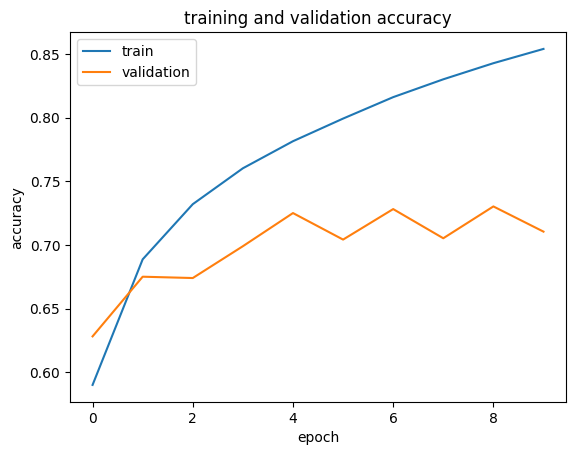

In [ ]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("training and validation accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(["train","validation"])

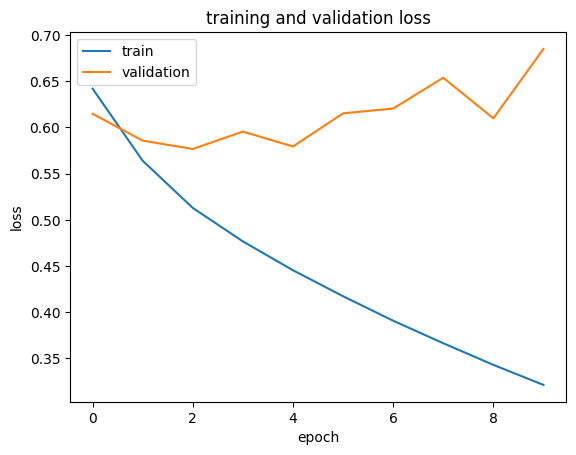

In [ ]:
plt.figure()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("training and validation loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["train","validation"])

In [ ]:
loss, accuracy = model.evaluate(tf_test)

413/413 [==============================] - 6s 14ms/step - loss: 0.8140 - accuracy: 0.6631


save model

In [ ]:
name = './model_'
if dataset_option == 0:
  name = name + 'rjokes_'
else:
  name = name + 'askreddit_'
if task_option == 0:
  name = name + 'classification_'
else:
  name = name + 'regression_'
if feature_option == 0:
  name = name + 'text_only'
else:
  name = name + 'text_and_time'
name = name + '.keras'
model.save(name)